Arquivo comparativo criado: Analises/Comparativo_Vazao.xlsx


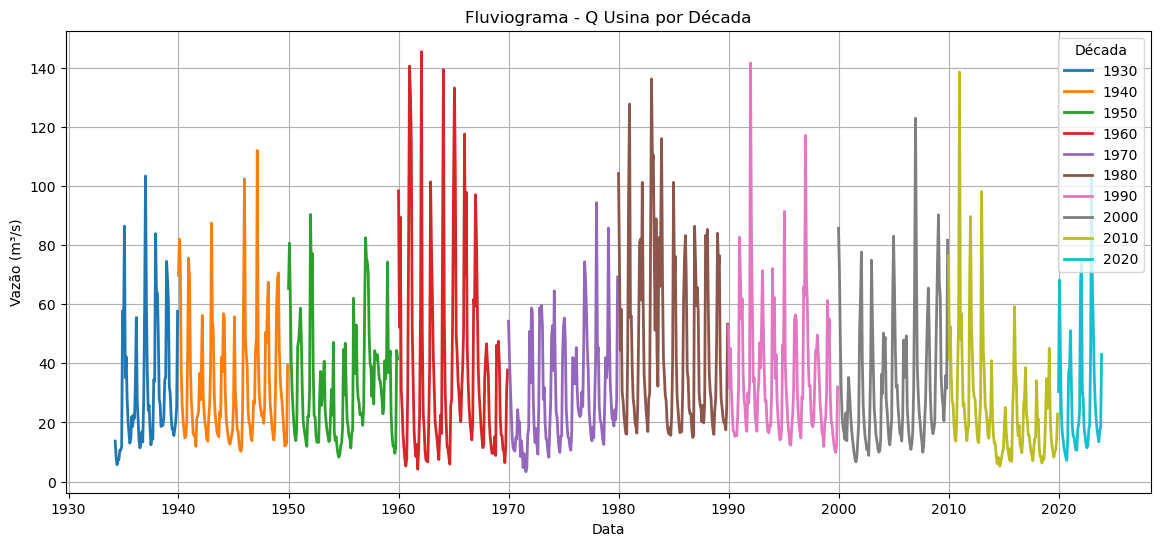

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import os

# -----------------------------
# Configurações iniciais
# -----------------------------
epsilon_log = 1e-6  # para estabilidade no log1p
os.makedirs("Graficos", exist_ok=True)
os.makedirs("Analises", exist_ok=True)

# -----------------------------
# Ler planilha
# -----------------------------
caminho_arquivo = "Cálculo da PCH-SOLAR.xlsx"
aba_escolhida = "Curva de Permanência"

df = pd.read_excel(caminho_arquivo, sheet_name=aba_escolhida, header=0)
df = df.dropna(axis=1, how='all')
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df['Q usina m³ [Vazão]'] = (
    df['Q usina m³ [Vazão]']
    .astype(str)
    .str.replace(' ', '')
    .str.replace(',', '.')
)
df['Q usina m³ [Vazão]'] = pd.to_numeric(df['Q usina m³ [Vazão]'], errors='coerce')
vazao_real = df['Q usina m³ [Vazão]'].dropna().reset_index(drop=True)

# -----------------------------
# CSV comparativo
# -----------------------------
vazao_decrescente = vazao_real.sort_values(ascending=False).reset_index(drop=True)
df_comparativo = pd.DataFrame({
    'Vazao_Real (m³/s)': vazao_real,
    'Vazao_Decrescente (m³/s)': vazao_decrescente,
    'Permanencia (%)': permanencia
})
df_stats = pd.DataFrame(list(estatisticas.items()), columns=['Estatística', 'Valor (m³/s)'])

with pd.ExcelWriter("Analises/Comparativo_Vazao.xlsx") as writer:
    df_comparativo.to_excel(writer, index=False, sheet_name='Série de Vazão')
    df_stats.to_excel(writer, index=False, sheet_name='Estatísticas')

print("Arquivo comparativo criado: Analises/Comparativo_Vazao.xlsx")

# -----------------------------
# Fluviograma por décadas
# -----------------------------
df_plot = df.copy()
df_plot['Ano'] = df_plot['Data'].dt.year
df_plot['Década'] = (df_plot['Ano'] // 10) * 10

plt.figure(figsize=(14,6))
sns.lineplot(data=df_plot, x='Data', y='Q usina m³ [Vazão]', hue='Década', palette='tab10', linewidth=2)
plt.xlabel('Data')
plt.ylabel('Vazão (m³/s)')
plt.title('Fluviograma - Q Usina por Década')
plt.legend(title='Década', loc='upper right')
plt.grid(True)
plt.savefig("Graficos/Fluviograma_QUsina_Decadas.png", dpi=300, bbox_inches='tight')
plt.show()


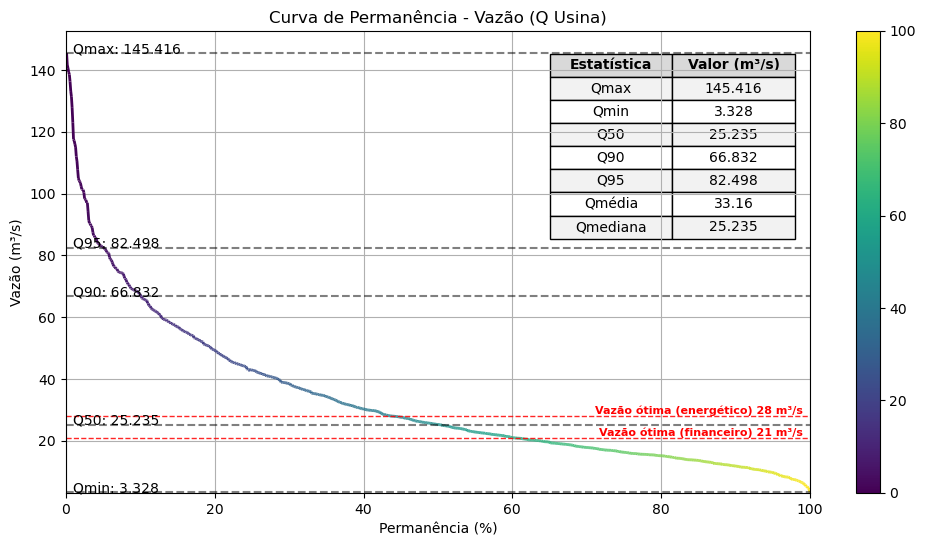

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import os

# -----------------------------
# Configurações iniciais
# -----------------------------
os.makedirs("Graficos", exist_ok=True)
os.makedirs("Analises", exist_ok=True)

# -----------------------------
# Ler planilha
# -----------------------------
caminho_arquivo = "Cálculo da PCH-SOLAR.xlsx"
aba_escolhida = "Curva de Permanência"

df = pd.read_excel(caminho_arquivo, sheet_name=aba_escolhida, header=0)
df = df.dropna(axis=1, how='all')

# -----------------------------
# Tratamento das colunas
# -----------------------------
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

for col in ['Q usina m³ [Vazão]', 'Permanência', 'Ph [kW]']:
    df[col] = (df[col]
               .astype(str)
               .str.replace(' ', '')
               .str.replace(',', '.'))
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Séries limpas
vazao_real = df['Q usina m³ [Vazão]'].dropna().reset_index(drop=True)
permanencia_real = df['Permanência'].dropna().reset_index(drop=True)
potencia_real = df['Ph [kW]'].dropna().reset_index(drop=True)


# =============================
# CURVA DE PERMANÊNCIA - VAZÃO
# =============================

# Estatísticas
estatisticas = {
    'Qmax': vazao_real.max(),
    'Qmin': vazao_real.min(),
    'Q50': np.percentile(vazao_real, 50),
    'Q90': np.percentile(vazao_real, 90),
    'Q95': np.percentile(vazao_real, 95),
    'Qmédia': vazao_real.mean(),
    'Qmediana': vazao_real.median()
}

# Ordenação
vazao_ord = vazao_real.sort_values(ascending=False).reset_index(drop=True)
permanencia_vazao = np.arange(1, len(vazao_ord)+1) / len(vazao_ord) * 100

segments = [
    [[permanencia_vazao[i], vazao_ord[i]],
     [permanencia_vazao[i+1], vazao_ord[i+1]]]
    for i in range(len(vazao_ord)-1)
]

lc = LineCollection(segments, cmap='viridis', linewidths=2)
lc.set_array(np.linspace(0, 100, len(segments)))

fig, ax = plt.subplots(figsize=(12,6))
ax.add_collection(lc)

ax.set_xlim(0, 100)
ax.set_ylim(vazao_ord.min()*0.95, vazao_ord.max()*1.05)
ax.set_xlabel('Permanência (%)')
ax.set_ylabel('Vazão (m³/s)')
ax.set_title('Curva de Permanência - Vazão (Q Usina)')
ax.grid(True)

# Linhas horizontais das estatísticas
for y, label in zip(
        [estatisticas['Qmax'], estatisticas['Qmin'], estatisticas['Q50'],
         estatisticas['Q90'], estatisticas['Q95']],
        ['Qmax', 'Qmin', 'Q50', 'Q90', 'Q95']):

    ax.axhline(y, linestyle='--', color='black', alpha=0.5)
    ax.text(1, y, f'{label}: {y:.3f}', fontsize=10, color='black')


# =============================
# TABELA DE ESTATÍSTICAS - VAZÃO
# =============================

df_estat_q = pd.DataFrame(
    {k: [round(v,3)] for k,v in estatisticas.items()}
).T.reset_index()

df_estat_q.columns = ['Estatística', 'Valor (m³/s)']

table_q = ax.table(
    cellText=df_estat_q.values,
    colLabels=df_estat_q.columns,
    cellLoc='center',
    colLoc='center',
    loc='upper right',
    bbox=[0.65, 0.55, 0.33, 0.40]     # << padrão igual ao da potência
)

table_q.auto_set_font_size(False)
table_q.set_fontsize(10)
table_q.scale(1, 1.2)

# Estilo zebrado
for i in range(len(df_estat_q)):
    for j in range(2):
        cell = table_q[i+1, j]
        cell.set_facecolor('#f2f2f2' if i % 2 == 0 else '#ffffff')
        cell.set_edgecolor('black')

# Cabeçalho
for j in range(2):
    cell = table_q[0, j]
    cell.set_facecolor('#d9d9d9')
    cell.set_edgecolor('black')
    cell.set_text_props(weight='bold')


# =============================
# DESTAQUE DAS VAZÕES ÓTIMAS
# =============================

vazoes_otimas = [
    (21, "Vazão ótima (financeiro) 21 m³/s"),
    (28, "Vazão ótima (energético) 28 m³/s")
]

x_max = ax.get_xlim()[1]

for valor, texto in vazoes_otimas:
    ax.axhline(valor, color='red', linestyle='--', linewidth=1, alpha=0.85)
    ax.text(
        x_max * 0.99,
        valor,
        texto,
        ha='right',
        va='bottom',
        fontsize=8,
        color='red',
        weight='bold'
    )

# Colorbar
cbar = fig.colorbar(lc, ax=ax)

plt.savefig("Graficos/Curva_Permanencia_QUsina.png", 
            dpi=300, bbox_inches='tight')
plt.show()


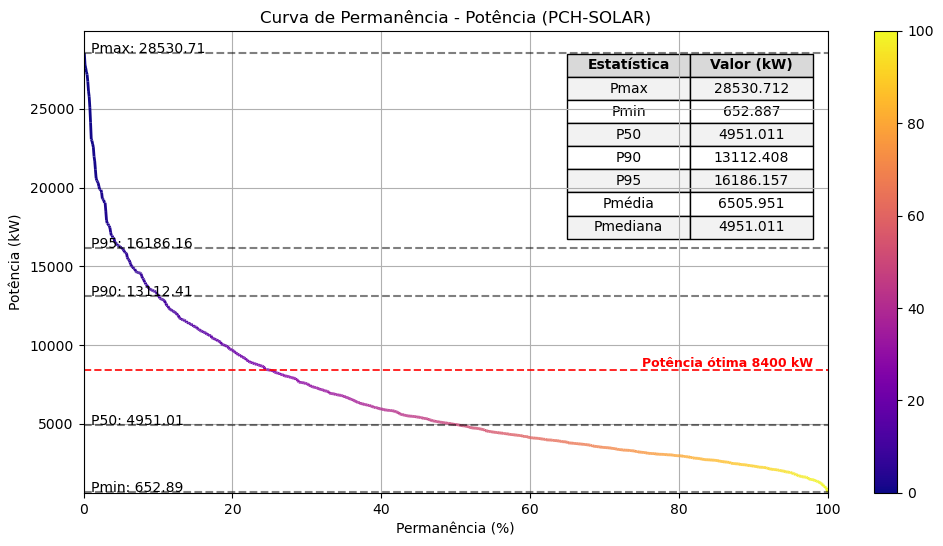

FINALIZADO ✔️
Arquivos criados em /Graficos e /Analises


In [14]:

# =============================
# CURVA DE PERMANÊNCIA - POTÊNCIA
# =============================

# Ordenar potência
pot_ord = potencia_real.sort_values(ascending=False).reset_index(drop=True)
permanencia_pot = np.arange(1, len(pot_ord)+1) / len(pot_ord) * 100

# Estatísticas potência
estat_pot = {
    'Pmax': pot_ord.max(),
    'Pmin': pot_ord.min(),
    'P50': np.percentile(pot_ord, 50),
    'P90': np.percentile(pot_ord, 90),
    'P95': np.percentile(pot_ord, 95),
    'Pmédia': pot_ord.mean(),
    'Pmediana': pot_ord.median()
}

segments2 = [[[permanencia_pot[i], pot_ord[i]], 
              [permanencia_pot[i+1], pot_ord[i+1]]] 
             for i in range(len(pot_ord)-1)]

lc2 = LineCollection(segments2, cmap='plasma', linewidths=2)
lc2.set_array(np.linspace(0, 100, len(segments2)))

fig2, ax2 = plt.subplots(figsize=(12,6))
ax2.add_collection(lc2)

ax2.set_xlim(0, 100)
ax2.set_ylim(pot_ord.min()*0.95, pot_ord.max()*1.05)
ax2.set_xlabel('Permanência (%)')
ax2.set_ylabel('Potência (kW)')
ax2.set_title('Curva de Permanência - Potência (PCH-SOLAR)')
ax2.grid(True)

for y, label in zip(
        [estat_pot['Pmax'], estat_pot['Pmin'], estat_pot['P50'],
         estat_pot['P90'], estat_pot['P95']],
        ['Pmax', 'Pmin', 'P50', 'P90', 'P95']):
    
    ax2.axhline(y, linestyle='--', color='black', alpha=0.5)
    ax2.text(1, y, f'{label}: {y:.2f}', fontsize=10, color='black')

cbar2 = fig2.colorbar(lc2, ax=ax2)

# =============================
# POTÊNCIA ÓTIMA (DESTACADA)
# =============================
pot_otima = 8400
texto_pot_otima = "Potência ótima 8400 kW"

# Linha horizontal
ax2.axhline(
    pot_otima,
    color='red',
    linestyle='--',
    linewidth=1.4,
    alpha=0.85
)

# Texto na direita
ax2.text(
    ax2.get_xlim()[1] * 0.98,   # posição horizontal (quase no canto direito)
    pot_otima,
    texto_pot_otima,
    ha='right',
    va='bottom',
    fontsize=9,
    color='red',
    weight='bold'
)


# -----------------------------
# TABELA DE ESTATÍSTICAS - POTÊNCIA
# -----------------------------
df_estat_pot = pd.DataFrame({k: [round(v,3)] for k,v in estat_pot.items()}).T.reset_index()
df_estat_pot.columns = ['Estatística', 'Valor (kW)']

table2 = ax2.table(cellText=df_estat_pot.values,
                   colLabels=df_estat_pot.columns,
                   cellLoc='center',
                   colLoc='center',
                   loc='upper right',
                   bbox=[0.65, 0.55, 0.33, 0.4])
table2.auto_set_font_size(False)
table2.set_fontsize(10)
table2.scale(1, 1.2)

# Estilo "zebrado"
for i in range(len(df_estat_pot)):
    for j in range(2):
        cell = table2[i+1, j]
        cell.set_facecolor('#f2f2f2' if i%2==0 else '#ffffff')
        cell.set_edgecolor('black')

# Cabeçalho
for j in range(2):
    cell = table2[0, j]
    cell.set_facecolor('#d9d9d9')
    cell.set_edgecolor('black')
    cell.set_text_props(weight='bold')


plt.savefig("Graficos/Curva_Permanencia_Potencia.png", 
            dpi=300, bbox_inches='tight')
plt.show()

# Excel potência
df_pot = pd.DataFrame({
    'Permanência (%)': permanencia_pot,
    'Potência (kW)': pot_ord
})
df_stats_pot = pd.DataFrame(list(estat_pot.items()), 
                            columns=['Estatística', 'Valor (kW)'])

with pd.ExcelWriter("Analises/Comparativo_Potencia.xlsx") as writer:
    df_pot.to_excel(writer, index=False, sheet_name='Permanência x Potência')
    df_stats_pot.to_excel(writer, index=False, sheet_name='Estatísticas')

print("FINALIZADO ✔️")
print("Arquivos criados em /Graficos e /Analises")